In [12]:
# Install google earth engine python API
# https://developers.google.com/earth-engine/python_install_manual
%pip install earthengine-api --upgrade pandas geopandas 
%pip install requests folium osmnx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import geopandas as gpd
import folium
import json

In [14]:
city_name = 'Sviatohirsk'
# Load boundary from ./data folder

gdf = gpd.read_file(f'./data/{city_name}_boundary.geojson')

# get bounding box
bounds = gdf.bounds

In [15]:
# Plot the bounds on the map with folium
# https://python-visualization.github.io/folium/

center=[(bounds.miny + bounds.maxy) / 2, (bounds.minx + bounds.maxx) / 2]
m = folium.Map(location=center, zoom_start=13)
folium.GeoJson(gdf).add_to(m)
m

/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities.py:102: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]


In [16]:
# Translate Lat/Lon bounds of the city to Quadkeys to download building footprints
import math

def lat_lon_to_pixel(latitude, longitude, zoom):
    sinLatitude = math.sin(latitude * math.pi/180)
    pixelX = ((longitude + 180) / 360) * 256 * 2**zoom
    pixelY = (0.5 - math.log((1 + sinLatitude) / (1 - sinLatitude)) / (4 * math.pi)) * 256 * 2**zoom
    return pixelX, pixelY

def pixel_to_tile(pixelX, pixelY):
    return int(math.floor(pixelX / 256)), int(math.floor(pixelY / 256))

def tile_to_quadkey(tileX, tileY, zoom):
    quadkey = ""
    for i in range(zoom, 0, -1):
        digit = 0
        mask = 1 << (i - 1)
        if (tileX & mask) != 0:
            digit += 1
        if (tileY & mask) != 0:
            digit += 2
        quadkey += str(digit)
    return quadkey

# Define the bounding box for Sviatohirsk
minlat, minlon, maxlat, maxlon = bounds.miny, bounds.minx, bounds.maxy, bounds.maxx

# Choose a zoom level (adjust as needed to cover the city area)
zoom_level = 12

# Convert the bounding box corners to pixel coordinates
min_pixelX, min_pixelY = lat_lon_to_pixel(minlat, minlon, zoom_level)
max_pixelX, max_pixelY = lat_lon_to_pixel(maxlat, maxlon, zoom_level)

# Convert pixel coordinates to tile coordinates
min_tileX, min_tileY = pixel_to_tile(min_pixelX, min_pixelY)
max_tileX, max_tileY = pixel_to_tile(max_pixelX, max_pixelY)

# Find Quadkeys for each corner (you might need to find all Quadkeys in the range for full coverage)
quadkey_min = tile_to_quadkey(min_tileX, min_tileY, zoom_level)
quadkey_max = tile_to_quadkey(max_tileX, max_tileY, zoom_level)


# Remove three last digits from the quadkey
# quadkey_min = quadkey_min[:-3]
# quadkey_max = quadkey_max[:-3]

print('Quadkey coordinates of the city:')
quadkey_min, quadkey_max

Quadkey coordinates of the city:


/var/folders/yq/0zz796hs77l_70crv1b3x6z80000gn/T/ipykernel_63434/3016248649.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sinLatitude = math.sin(latitude * math.pi/180)
/var/folders/yq/0zz796hs77l_70crv1b3x6z80000gn/T/ipykernel_63434/3016248649.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return int(math.floor(pixelX / 256)), int(math.floor(pixelY / 256))


('120312323231', '120312323213')

In [17]:
# Adjusting the approach to account for the full-length Quadkeys

# Define the full-length Quadkeys
def quadkey_to_tile(quadkey):
    tileX, tileY = 0, 0
    zoom = len(quadkey)
    for i in range(zoom, 0, -1):
        mask = 1 << (i - 1)
        if quadkey[zoom - i] == '1':
            tileX |= mask
        elif quadkey[zoom - i] == '2':
            tileY |= mask
        elif quadkey[zoom - i] == '3':
            tileX |= mask
            tileY |= mask
    return tileX, tileY, zoom

# Convert full-length Quadkeys back to tile coordinates
min_tileX, min_tileY, zoom = quadkey_to_tile(quadkey_min)
max_tileX, max_tileY, _ = quadkey_to_tile(quadkey_max)

# Ensure the min and max tile ranges are valid
min_tileX, max_tileX = sorted([min_tileX, max_tileX])
min_tileY, max_tileY = sorted([min_tileY, max_tileY])

# Generate list of all Quadkeys in the bounding box
all_quadkeys = []
for tileX in range(min_tileX, max_tileX + 1):
    for tileY in range(min_tileY, max_tileY + 1):
        all_quadkeys.append(tile_to_quadkey(tileX, tileY, len(quadkey_min)))

all_quadkeys_cropped = list(set(map(lambda x: int(x[:-3]), all_quadkeys)))
all_quadkeys_cropped

[120312323]

In [18]:
# https://github.com/microsoft/GlobalMLBuildingFootprints/blob/main/scripts/make-gis-friendly.py

# Get polygons of building footprints for selected bounding box from Microsoft Building Footprints dataset
from shapely.geometry import shape
import os

# this is the name of the geography you want to retrieve. update to meet your needs
country = 'Ukraine'

dataset_links = pd.read_csv("https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv")
ukraine_links = dataset_links[dataset_links.Location == country]
sviatohirsk_links = ukraine_links[ukraine_links.QuadKey.isin(all_quadkeys_cropped)]

print('Total Links: ', len(sviatohirsk_links))

footprints = []
for _, row in sviatohirsk_links.iterrows():
    df = pd.read_json(row.Url, lines=True)
    df['geometry'] = df['geometry'].apply(shape)
    footprints.append(gpd.GeoDataFrame(df, crs=4326))

footprints = pd.concat(footprints)
footprints = gpd.overlay(footprints, gdf, how='intersection')

# Filter footprints by the city bounds
footprints.to_file(f'./data/{city_name}_msml_buildings.geojson', driver='GeoJSON')


Total Links:  1


<Axes: >

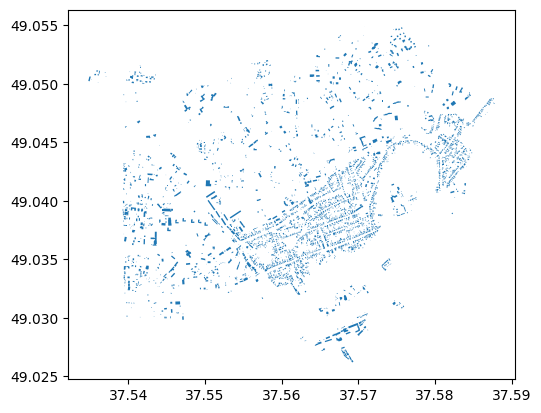

In [19]:
footprints.plot()

In [20]:
# show resulting buildings with folium
m = folium.Map(location=center, zoom_start=14)
folium.GeoJson(footprints).add_to(m)
folium.GeoJson(gdf).add_to(m)
m

/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/Users/hermanmitish/private/satellite-analysis/.conda/lib/python3.11/site-packages/folium/utilities.py:102: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]
